In [1]:
import torch
torch.cuda.is_available()

False

In [1]:
# !pip install nltk
# import nltk
# nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
# from bs4 import BeautifulSoup
# import plotly.graph_objs as go
# # import plotly.plotly as py
# import cufflinks
# from IPython.core.interactiveshell import InteractiveShell
# import plotly.figure_factory as ff
# InteractiveShell.ast_node_interactivity = 'all'
# from plotly.offline import iplot
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
path = '/content/drive/MyDrive/Datas/Tweet Proj/delhi/'

In [40]:
df = pd.read_csv(path+'delhi_data.csv')
df

,Unnamed: 0,Tweet,label
0,0,Traffic coming from Rohini towards Mukundpur...,Others
1,1,so that concerned area traffic staff can be i...,Traffic information/advisory
2,2,The authority concerned has been given tentat...,Others
3,3,A tree has fallen down at Gate no High Court,Others
4,4,and reach RA Samrat And another rehearsal wil...,Others
...,...,...,...
15433,15433,Your views please on this road project Satyend...,Others
15434,15434,YPoint on Choudhary Dilip Singh Marg Hauz Khas...,Road closure
15435,15435,ZainDh Sir due to demonstration of taxi driver...,Traffic congestion/heavy traffic
15436,15436,Zakhira on New Rohtak RoadVehicle coming from ...,Others


In [18]:
# df.label.replace({0:'Traffic obstruction/car breakdown',1:'Water logging', 2:'Traffic congestion/heavy traffic',3:'Road closure', 4:'City program', 5:'Accident', 6:'Traffic information/advisory',-1:'Others'},inplace=True)

In [41]:
# df = df.iloc[:,1:]
df.dropna(inplace=True)
# df = df[df.Narrative != 'name']
# df.reset_index(inplace=True)
df

,Unnamed: 0,Tweet,label
0,0,Traffic coming from Rohini towards Mukundpur...,Others
1,1,so that concerned area traffic staff can be i...,Traffic information/advisory
2,2,The authority concerned has been given tentat...,Others
3,3,A tree has fallen down at Gate no High Court,Others
4,4,and reach RA Samrat And another rehearsal wil...,Others
...,...,...,...
15433,15433,Your views please on this road project Satyend...,Others
15434,15434,YPoint on Choudhary Dilip Singh Marg Hauz Khas...,Road closure
15435,15435,ZainDh Sir due to demonstration of taxi driver...,Traffic congestion/heavy traffic
15436,15436,Zakhira on New Rohtak RoadVehicle coming from ...,Others


In [21]:
# df.to_csv(path+'delhi_data.csv')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15438 entries, 0 to 15437
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15438 non-null  int64 
 1   Tweet       15438 non-null  object
 2   label       15438 non-null  object
dtypes: int64(1), object(2)
memory usage: 362.0+ KB


In [43]:
df.label.value_counts()

Traffic obstruction/car breakdown    4831
Others                               3459
Traffic congestion/heavy traffic     2821
Road closure                         1487
Water logging                        1156
Traffic information/advisory         1001
City program                          416
Accident                              267
Name: label, dtype: int64

[Text(0, 0, 'Others'),
 Text(1, 0, 'Traffic information/advisory'),
 Text(2, 0, 'Accident'),
 Text(3, 0, 'Traffic congestion/heavy traffic'),
 Text(4, 0, 'Water logging'),
 Text(5, 0, 'City program'),
 Text(6, 0, 'Traffic obstruction/car breakdown'),
 Text(7, 0, 'Road closure')]

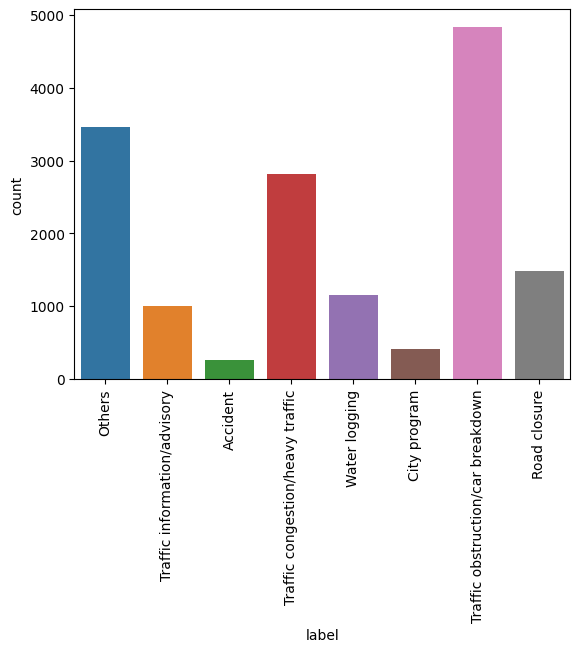

In [44]:
s = sns.countplot(x='label',data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

In [45]:
def print_plot(index):
    example = df[df.index == index][['Tweet', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [46]:
print_plot(10)

 BRIG HOSHIYAR SINGH MARG AUROBINDO MARGPRITHVI RAJ ROAD in connection with Airtel Delhi Half Marathon Championship 
Product: Others


In [47]:
print_plot(100)

and to complain online you may also visit at their website 
Product: Others


In [48]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Tweet'] = df['Tweet'].apply(clean_text)

In [49]:
df['Tweet'] = df['Tweet'].str.replace('\d+', '')

<ipython-input-49-7a21faa3365b>:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [50]:
print_plot(10)

brig hoshiyar singh marg aurobindo margprithvi raj road connection airtel delhi half marathon championship
Product: Others


In [51]:
print_plot(100)

complain online may also visit website
Product: Others


In [53]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 120
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8212 unique tokens.


In [54]:
X = tokenizer.texts_to_sequences(df['Tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
X

Shape of data tensor: (15438, 120)


array([[   0,    0,    0, ...,  840, 4367,    5],
       [   0,    0,    0, ...,    1,   33,   56],
       [   0,    0,    0, ...,  891,   19, 1259],
       ...,
       [   0,    0,    0, ...,  114,  483,    1],
       [   0,    0,    0, ...,  362,  194,   82],
       [   0,    0,    0, ...,  411,    1,   23]], dtype=int32)

In [55]:
label_encoder=LabelEncoder()
Y = df['label'].values
label_encoder.fit(Y)
y=label_encoder.transform(Y)
classes=label_encoder.classes_
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
y

LabelEncoder()

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
# Y1 = pd.get_dummies(df['label']).values
# print('Shape of label tensor:', Y1.shape)

Shape of label tensor: (8327, 6)


In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(12350, 120) (12350, 8)
(3088, 120) (3088, 8)


In [57]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          500000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 120, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
Total params: 581,208
Trainable params: 581,208
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
import keras
epochs = 15
batch_size = 32

checkpoint_filepath = '/content/drive/MyDrive/Models/TweetClassification/'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[model_checkpoint_callback])

Epoch 1/15
348/348 [==============================] - 150s 420ms/step - loss: 0.8032 - accuracy: 0.7351 - val_loss: 0.2978 - val_accuracy: 0.8996
Epoch 2/15
348/348 [==============================] - 120s 344ms/step - loss: 0.1584 - accuracy: 0.9533 - val_loss: 0.1289 - val_accuracy: 0.9595
Epoch 3/15
348/348 [==============================] - 107s 308ms/step - loss: 0.0684 - accuracy: 0.9819 - val_loss: 0.0821 - val_accuracy: 0.9700
Epoch 4/15
348/348 [==============================] - 106s 305ms/step - loss: 0.0451 - accuracy: 0.9870 - val_loss: 0.0807 - val_accuracy: 0.9757
Epoch 5/15
348/348 [==============================] - 106s 306ms/step - loss: 0.0392 - accuracy: 0.9897 - val_loss: 0.0823 - val_accuracy: 0.9765
Epoch 6/15
348/348 [==============================] - 105s 301ms/step - loss: 0.0291 - accuracy: 0.9919 - val_loss: 0.0804 - val_accuracy: 0.9749
Epoch 7/15
348/348 [==============================] - 105s 303ms/step - loss: 0.0180 - accuracy: 0.9951 - val_loss: 0.0668 -

# Save Model and History

In [60]:
import pickle
with open(path+'delhi_LSTM_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [61]:
model.save(path+'delhi_LSTM_model.h5')

# Load Model and History

In [62]:
from tensorflow import keras
model = keras.models.load_model(path+'delhi_LSTM_model.h5')

In [ ]:
import pickle
with open(path+'delhi_LSTM_history', "rb") as file_pi:
  history = pickle.load(file_pi)

# Perform on Test Dataset

In [63]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

97/97 [==============================] - 6s 53ms/step - loss: 0.1034 - accuracy: 0.9780
Test set
  Loss: 0.103
  Accuracy: 0.978


# Plot Result

In [64]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 328ms/step
[[7.7965384e-04 2.2269848e-03 7.8691882e-01 2.5177305e-03 1.7872164e-03
  2.0426075e-01 6.3585112e-04 8.7305845e-04]] Mortgage


In [65]:
epochs = 10

97/97 [==============================] - 4s 37ms/step - loss: 0.1034 - accuracy: 0.9780
Accuracy of our model on test data :  97.7979302406311 %


Text(0.5, 1.0, 'Training & Testing Loss')

Text(0.5, 0, 'Epochs')

Text(0.5, 1.0, 'Training & Testing Accuracy')

Text(0.5, 0, 'Epochs')

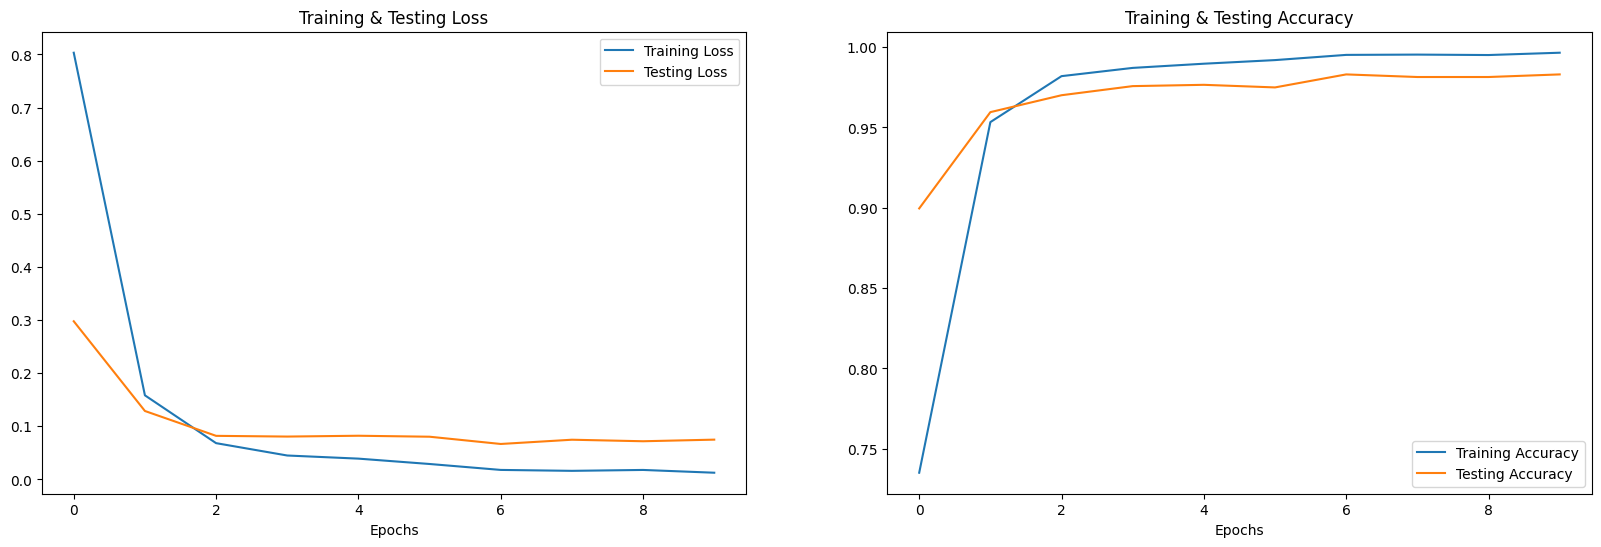

In [66]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [67]:
# predicting on test data.
pred_test = model.predict(X_test)


97/97 [==============================] - 4s 41ms/step


In [68]:
pred_test

array([[5.6712030e-05, 8.7883142e-05, 5.0511264e-04, ..., 4.8435606e-05,
        9.1386013e-05, 1.8804476e-05],
       [2.2495326e-05, 9.4055158e-06, 3.1725594e-04, ..., 4.0575778e-05,
        2.4911955e-05, 8.6023238e-06],
       [2.8951054e-06, 1.2254224e-05, 9.9987507e-01, ..., 1.9145144e-05,
        9.4482575e-06, 7.6500901e-06],
       ...,
       [2.5269287e-04, 1.8138907e-04, 9.9150282e-01, ..., 5.5741831e-03,
        3.3351933e-04, 1.1604700e-03],
       [1.3254448e-05, 4.5592660e-05, 3.7206076e-03, ..., 2.0369484e-05,
        5.5120374e-05, 1.1964008e-05],
       [1.5755941e-05, 1.5451076e-05, 3.3959543e-06, ..., 9.9989635e-01,
        8.0172919e-07, 5.3365089e-05]], dtype=float32)

In [69]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# encoder = OneHotEncoder()
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(Y_test)

<Figure size 1200x1000 with 0 Axes>

<Axes: xlabel='None', ylabel='None'>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 80.7222222222222, 'Predicted Labels')

Text(120.72222222222221, 0.5, 'Actual Labels')

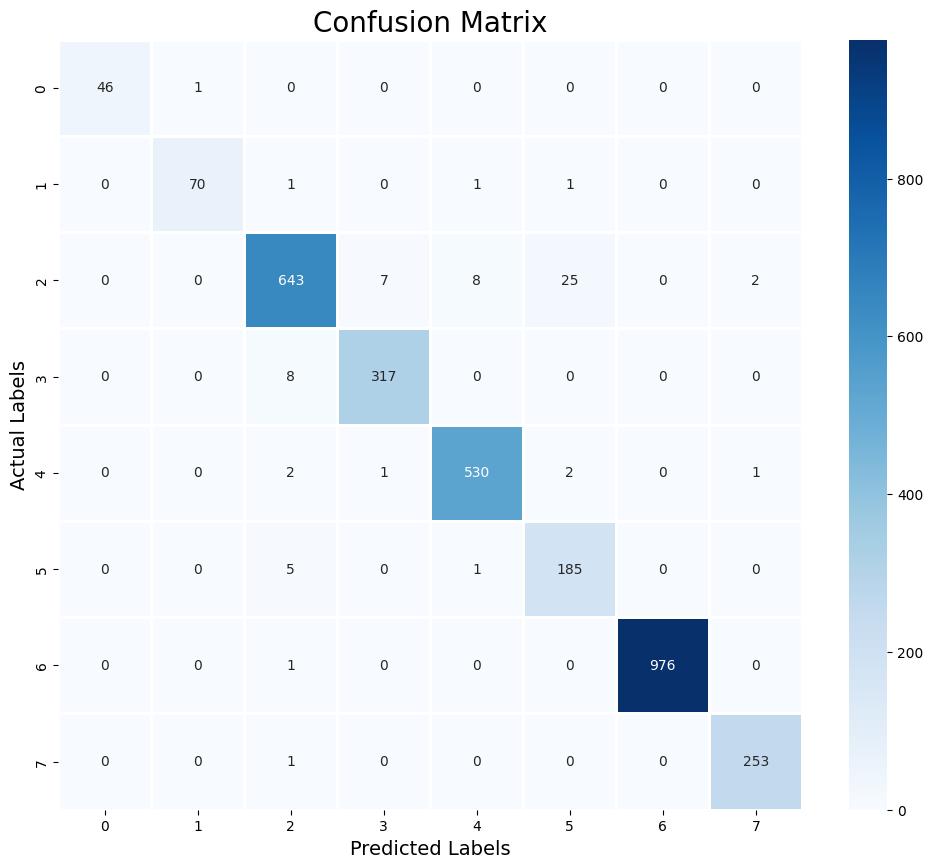

In [70]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.99      0.96      0.97        73
           2       0.97      0.94      0.96       685
           3       0.98      0.98      0.98       325
           4       0.98      0.99      0.99       536
           5       0.87      0.97      0.92       191
           6       1.00      1.00      1.00       977
           7       0.99      1.00      0.99       254

    accuracy                           0.98      3088
   macro avg       0.97      0.98      0.97      3088
weighted avg       0.98      0.98      0.98      3088



(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 1.0, 'Multiclass ROC curve')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive rate')

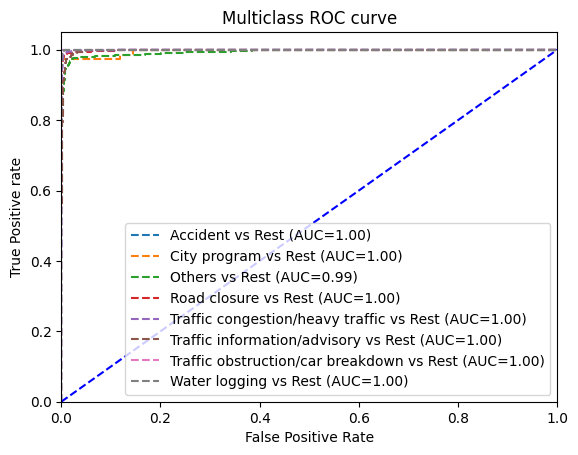

In [72]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc
pred_prob = pred_test
from sklearn.preprocessing import label_binarize
#binarize the y_values

y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [73]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, pred_prob,multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9982618808970016
